# CLASSIFICATION

In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from termcolor import colored
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import matplotlib as mpl
from matplotlib import colors
from scipy import linalg

## Part1: Data preparation

In [15]:
# Read the data from the file
# Data from https://www.kaggle.com/blastchar/telco-customer-churn
import requests
excel_url = 'https://docs.google.com/spreadsheets/d/1bE6UqoRIz3pi0vyXETpj8uT4Difb9z-CeONBEGfSryo/export?format=xlsx'
response = requests.get(excel_url)
response.raise_for_status()  # Ensure the request was successful
with open('sheet.xlsx', 'wb') as file:
    file.write(response.content)
df = pd.read_excel('sheet.xlsx')

In [16]:
# Check the first few lines to see the column names and type of content
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
# Size of the dataframe
df.shape

(7043, 21)

In [18]:
# Remove rows with empty values
df = df.replace(r'^\s*$', float('NaN'), regex = True)
df.dropna(inplace = True)
df.shape

(7032, 21)

In [19]:
# Let us check the types of the different columns
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [20]:
# Let us adapt the dataframe (remove customerID, and make sure that columns have the right type)
del df['customerID']
df['gender'] = df['gender'].astype('category')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['Partner'] = df['Partner'].astype('category')
df['Dependents'] = df['Dependents'].astype('category')
df['tenure'] = df['tenure'].astype(float)
df['PhoneService'] = df['PhoneService'].astype('category')
df['MultipleLines'] = df['MultipleLines'].astype('category')
df['InternetService'] = df['InternetService'].astype('category')
df['OnlineSecurity'] = df['OnlineSecurity'].astype('category')
df['OnlineBackup'] = df['OnlineBackup'].astype('category')
df['DeviceProtection'] = df['DeviceProtection'].astype('category')
df['TechSupport'] = df['TechSupport'].astype('category')
df['StreamingTV'] = df['StreamingTV'].astype('category')
df['StreamingMovies'] = df['StreamingMovies'].astype('category')
df['Contract'] = df['Contract'].astype('category')
df['PaperlessBilling'] = df['PaperlessBilling'].astype('category')
df['PaymentMethod'] = df['PaymentMethod'].astype('category')
df['Churn'] = df['Churn'].astype('category')
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [21]:
df['TotalCharges'].head(10)

,TotalCharges
0,29.85
1,1889.50
2,108.15
3,1840.75
4,151.65
5,820.50
6,1949.40
7,301.90
8,3046.05
9,3487.95


In [22]:
# final dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   float64 
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 non-nu

## Part 2: Data exploration

In [23]:
# Lets see the summary of the numerical columns
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


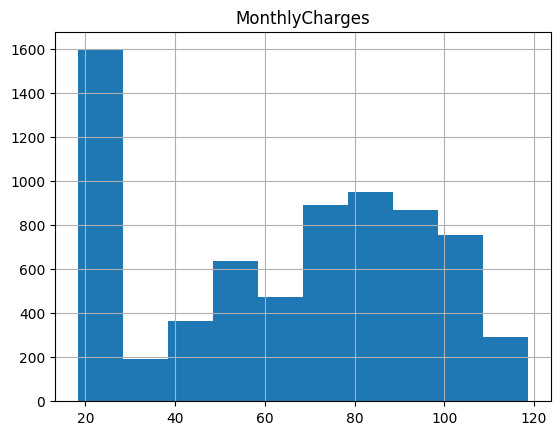

In [24]:
# Histogram of charges
df.hist(column="MonthlyCharges");

<ipython-input-25-8a9881bfd395>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['MonthlyCharges'].hist(by=df['gender'])


array([<Axes: title={'center': 'Female'}>,
       <Axes: title={'center': 'Male'}>], dtype=object)

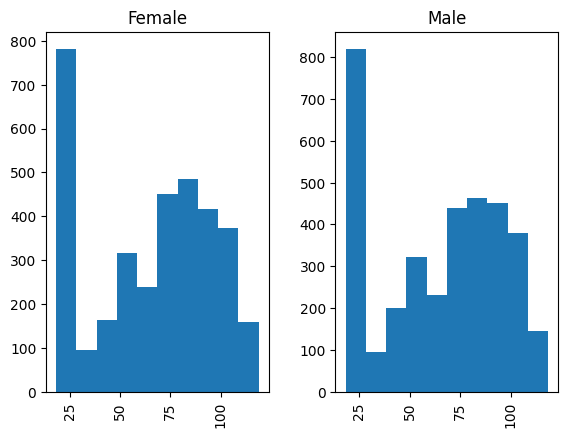

In [25]:
# Check if there are differences by sex
df['MonthlyCharges'].hist(by=df['gender'])

<ipython-input-26-41fe510f4505>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['MonthlyCharges'].hist(by=df['SeniorCitizen'])


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

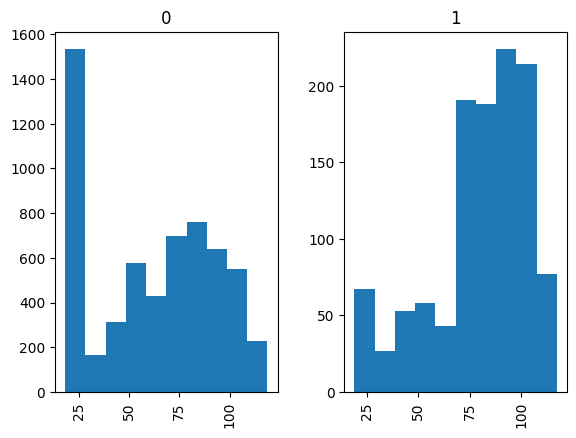

In [26]:
# Or differences by seniority
df['MonthlyCharges'].hist(by=df['SeniorCitizen'])

We now check the relationship betweeen each variable and churning. Let us see first the overall probability of churning

In [27]:
print('Baseline p(Churning)=%f'%(float(np.sum(df['Churn']=='Yes'))/len(df)))

Baseline p(Churning)=0.265785


In [28]:
typeDict = dict(df.dtypes)
for column in df.columns:
    if column=='Churn':
        continue
    if typeDict[column]=="category":
        contingencyNormalized=pd.crosstab(df[column],df["Churn"],normalize='index')
        contingency=pd.crosstab(df[column],df["Churn"])
        print(contingencyNormalized)
        c, p, dof, expected = scipy.stats.chi2_contingency(contingency)
    elif typeDict[column]=="float64":
        xYes = df[column][df["Churn"]=="Yes"]
        xNo  = df[column][df["Churn"]=="No"]
        result = ks_2samp(xYes, xNo)
        print(column)
        print("Mean Yes=%f, No=%f"%(np.mean(xYes),np.mean(xNo)))
        p = result.pvalue
    if p<0.05:
        color='green'
    else:
        color='red'
    print(colored('p-value=%f'%p,color))
    print("--------------------------------------------")

Churn         No       Yes
gender                    
Female  0.730405  0.269595
Male    0.737954  0.262046
p-value=0.490488
--------------------------------------------
Churn                No       Yes
SeniorCitizen                    
0              0.763497  0.236503
1              0.583187  0.416813
p-value=0.000000
--------------------------------------------
Churn          No       Yes
Partner                    
No       0.670239  0.329761
Yes      0.802829  0.197171
p-value=0.000000
--------------------------------------------
Churn             No       Yes
Dependents                    
No          0.687209  0.312791
Yes         0.844688  0.155312
p-value=0.000000
--------------------------------------------
tenure
Mean Yes=17.979133, No=37.650010
p-value=0.000000
--------------------------------------------
Churn               No       Yes
PhoneService                    
No            0.750000  0.250000
Yes           0.732525  0.267475
p-value=0.349924
---------------------

<Axes: xlabel='Churn', ylabel='tenure'>

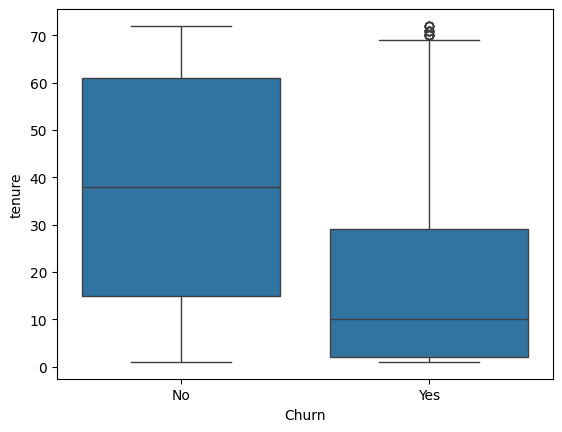

In [29]:
sns.boxplot(x='Churn', y='tenure', data=df)

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

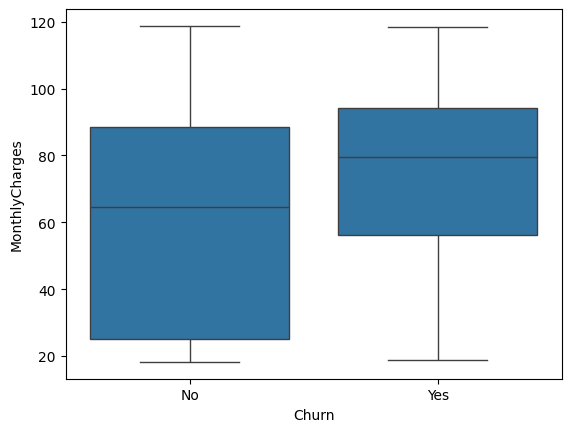

In [30]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)

<Axes: xlabel='Churn', ylabel='TotalCharges'>

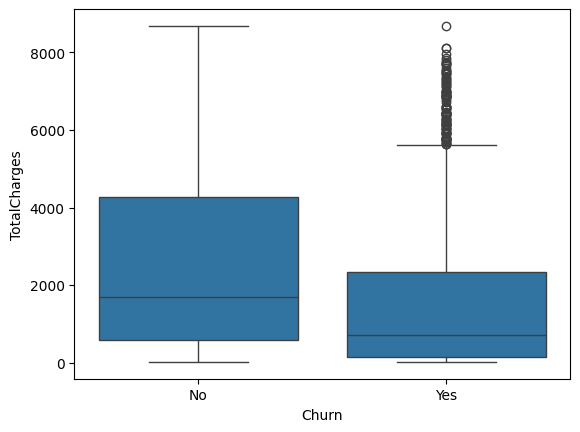

In [31]:
sns.boxplot(x='Churn', y='TotalCharges', data=df)

## Classification tree

#### Train and test

We want to determine a model to predict Churn from the remaining variables. We will introduce now a new idea that is that in order to test the validity of a model, we need to keep data aside so that we can evaluate the performance of the model on the unseen data

In [32]:
percentage_test_data = 0.2

df_train, df_test = train_test_split(df,
                                     test_size = percentage_test_data,  # percentage of test data
                                     random_state = 0) # seed for replication

In [33]:
# set candidate input variables (predictors)

predictors = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService',
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']
X_train = df_train[predictors]
y_train = df_train['Churn']
X_test = df_test[predictors]
y_test = df_test['Churn']

A classification is a problem of the form y=f(X) where y is categorical and X is whatever

In [34]:
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2964,0,Yes,No,24.0,Yes,DSL,Yes,No,No,Yes,No,No,One year,Yes,Electronic check,58.35
5113,0,Yes,Yes,71.0,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),113.65
5363,0,Yes,Yes,70.0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35
5074,0,No,Yes,49.0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.45
156,0,No,No,22.0,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),84.15


In [35]:
y_train.head()

,Churn
2964,No
5113,No
5363,No
5074,No
156,No


The implementation of the classification tree in sklearn only deals with numerical variables, then we need to convert categorical to numerical variables.

In [36]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
df_feature_names = list(X_train.columns)
df_target_names = [str(s) for s in y_train.unique()]
X_train.head()

,tenure,MonthlyCharges,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_No phone service,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2964,24.0,58.35,True,False,False,True,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
5113,71.0,113.65,True,False,False,True,False,True,False,False,...,True,False,False,True,True,False,False,True,False,False
5363,70.0,25.35,True,False,False,True,False,True,False,False,...,False,False,False,True,True,False,False,False,False,True
5074,49.0,19.45,True,False,True,False,False,True,True,False,...,False,False,True,False,True,False,False,True,False,False
156,22.0,84.15,True,False,True,False,True,False,False,False,...,False,True,False,False,False,True,True,False,False,False


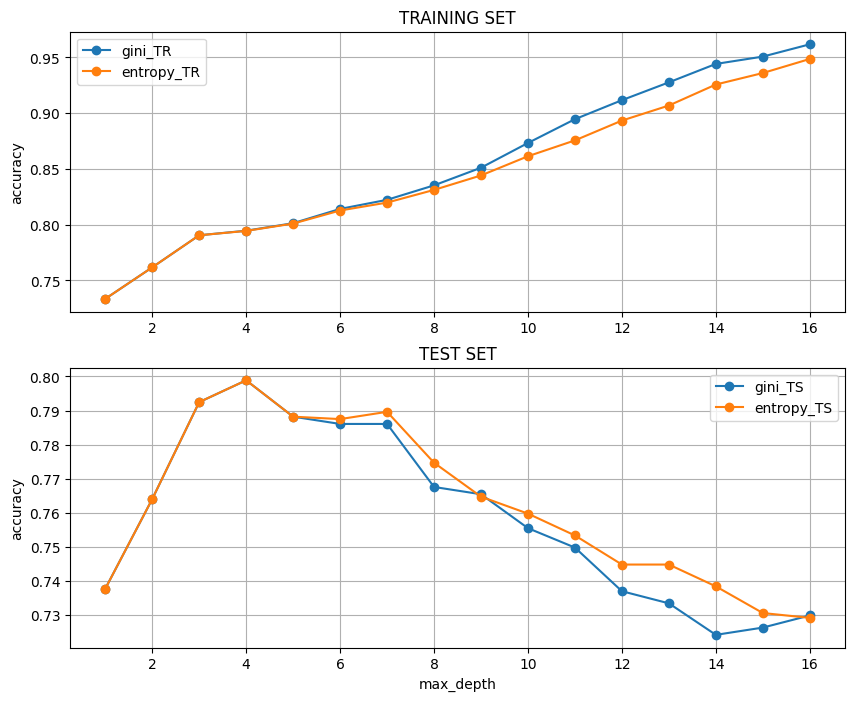

In [37]:
#  grid search in max_depth for selecting good complexity
max_depth = []
acc_gini_TR = []
acc_entropy_TR = []
acc_gini_TS = []
acc_entropy_TS = []

for i in range(1,17):
    clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=i)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    acc_gini_TR.append(metrics.accuracy_score(y_train, y_train_pred))
    acc_gini_TS.append(metrics.accuracy_score(y_test, y_test_pred))

    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    acc_entropy_TR.append(metrics.accuracy_score(y_train, y_train_pred))
    acc_entropy_TS.append(metrics.accuracy_score(y_test, y_test_pred))

    max_depth.append(i)

d = pd.DataFrame({'acc_gini_TR':pd.Series(acc_gini_TR),
                  'acc_entropy_TR':pd.Series(acc_entropy_TR),
                  'acc_gini_TS':pd.Series(acc_gini_TS),
                  'acc_entropy_TS':pd.Series(acc_entropy_TS),
                  'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2,1,1)
plt.plot('max_depth','acc_gini_TR', data=d, marker ='o', label='gini_TR')
plt.plot('max_depth','acc_entropy_TR', data=d, marker ='o', label='entropy_TR')
plt.title('TRAINING SET')
plt.grid()
plt.legend()
plt.ylabel('accuracy')
plt.subplot(2,1,2, sharex = ax1)
plt.plot('max_depth','acc_gini_TS', data=d, marker ='o', label='gini_TS')
plt.plot('max_depth','acc_entropy_TS', data=d, marker ='o', label='entropy_TS')
plt.title('TEST SET')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

With a maximum depth of 5 we already have quite a good classification accuracy (about 80%).

In [38]:
max_depth = 5
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
clf.fit(X_train, y_train)
print('Number of nodes:', clf.tree_.node_count)

Number of nodes: 61


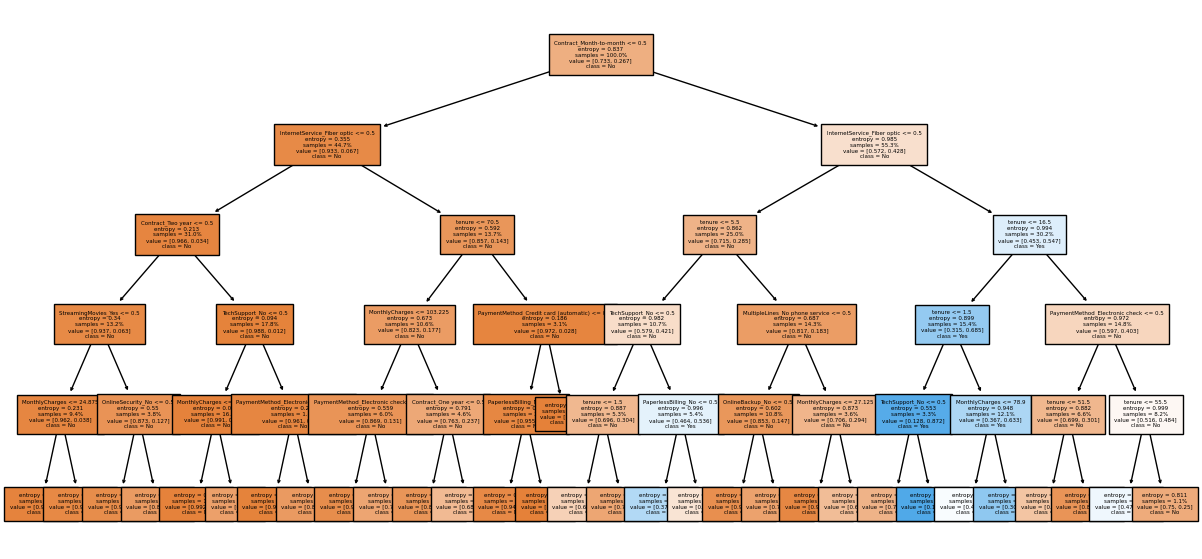

In [39]:
fig = plt.figure(figsize=(15,7))
_ = tree.plot_tree(clf,
                   feature_names=df_feature_names,
                   class_names=df_target_names,
                   proportion=True,
                   fontsize=4,
                   filled=True)

We cannot see much, let's have a text version of it

In [40]:
print(tree.export_text(clf, feature_names=df_feature_names))

|--- Contract_Month-to-month <= 0.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- Contract_Two year <= 0.50
|   |   |   |--- StreamingMovies_Yes <= 0.50
|   |   |   |   |--- MonthlyCharges <= 24.88
|   |   |   |   |   |--- class: No
|   |   |   |   |--- MonthlyCharges >  24.88
|   |   |   |   |   |--- class: No
|   |   |   |--- StreamingMovies_Yes >  0.50
|   |   |   |   |--- OnlineSecurity_No <= 0.50
|   |   |   |   |   |--- class: No
|   |   |   |   |--- OnlineSecurity_No >  0.50
|   |   |   |   |   |--- class: No
|   |   |--- Contract_Two year >  0.50
|   |   |   |--- TechSupport_No <= 0.50
|   |   |   |   |--- MonthlyCharges <= 92.42
|   |   |   |   |   |--- class: No
|   |   |   |   |--- MonthlyCharges >  92.42
|   |   |   |   |   |--- class: No
|   |   |   |--- TechSupport_No >  0.50
|   |   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |   |--- class: No
|   |   |   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |   |   |--- class:

Accuracy in Training with max_depth=5 is 0.800889
Accuracy in Test set with max_depth=5 is 0.788202


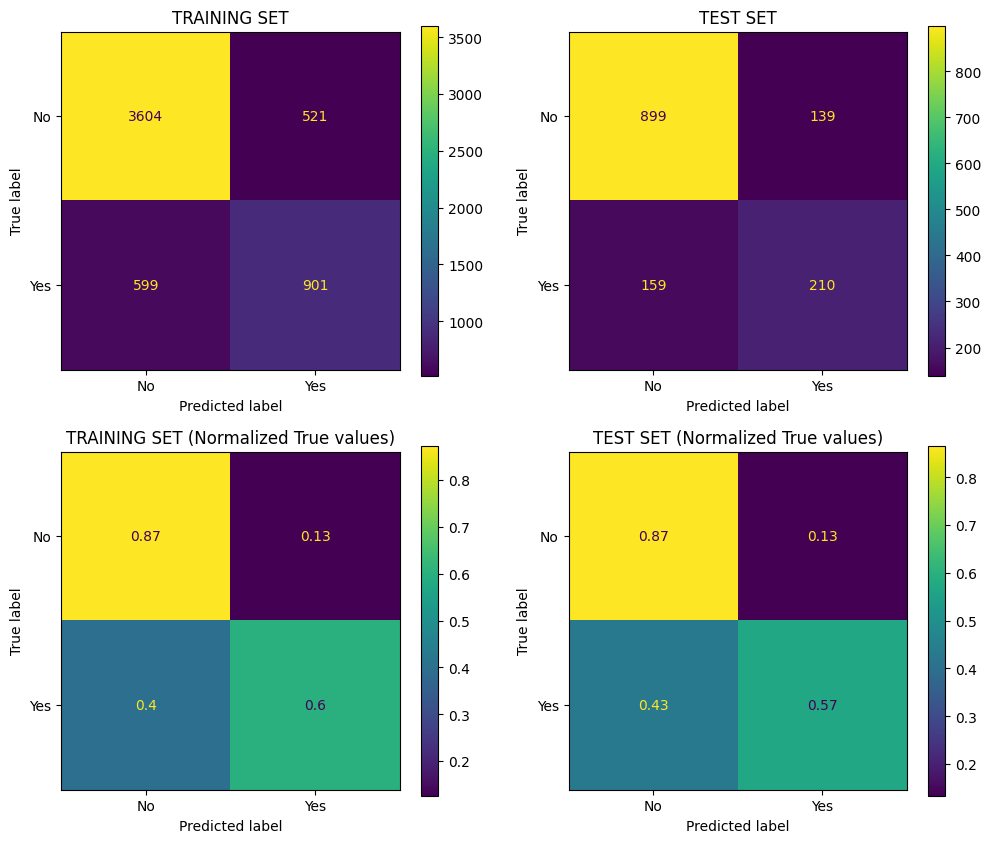

In [41]:
# accuracy and confusion matrix (TR and TS)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy in Training with max_depth=%d is %f'%(max_depth,metrics.accuracy_score(y_train,y_train_pred)))
print('Accuracy in Test set with max_depth=%d is %f'%(max_depth,metrics.accuracy_score(y_test,y_test_pred)))

fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

## Extremely simple classifier

We note that the last level of the tree above is not really separating anything (both labels in the split are equal). Then, we may further prune the tree.

In [42]:
max_depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
clf.fit(X_train, y_train)
print('Number of nodes:', clf.tree_.node_count)

Number of nodes: 15


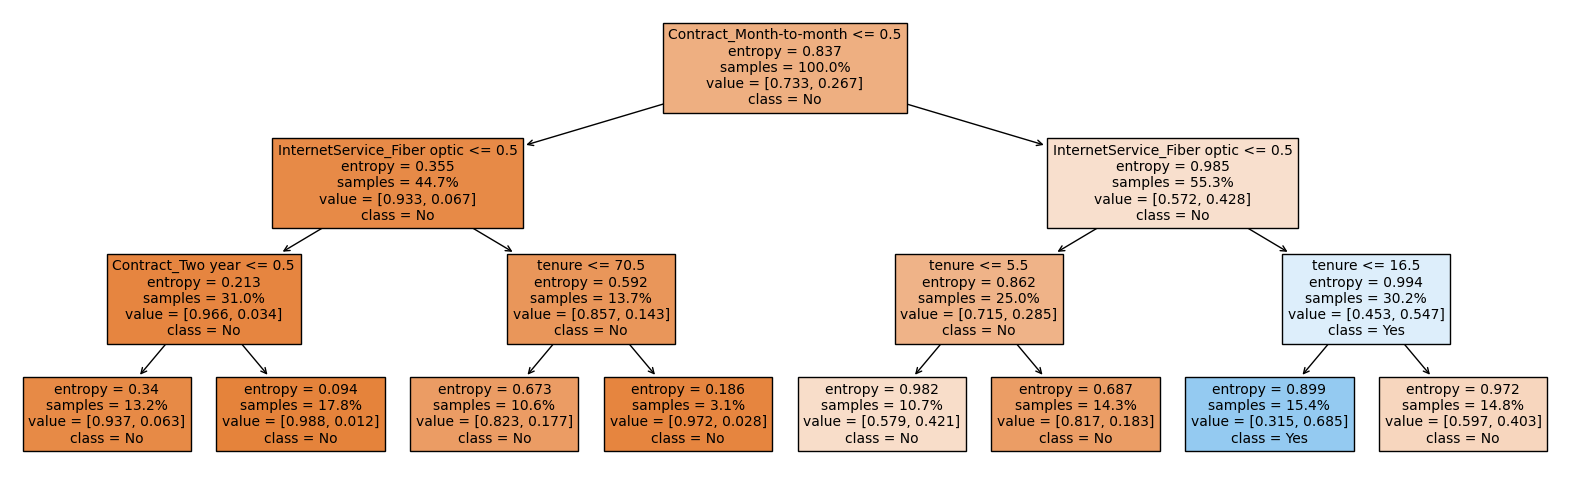

In [43]:
fig = plt.figure(figsize=(20,6))
_ = tree.plot_tree(clf,
                   feature_names=df_feature_names,
                   class_names=df_target_names,
                   proportion=True,
                   fontsize=10,
                   filled=True)

Accuracy in Training with max_depth=3 is 0.790400
Accuracy in Test set with max_depth=3 is 0.792466


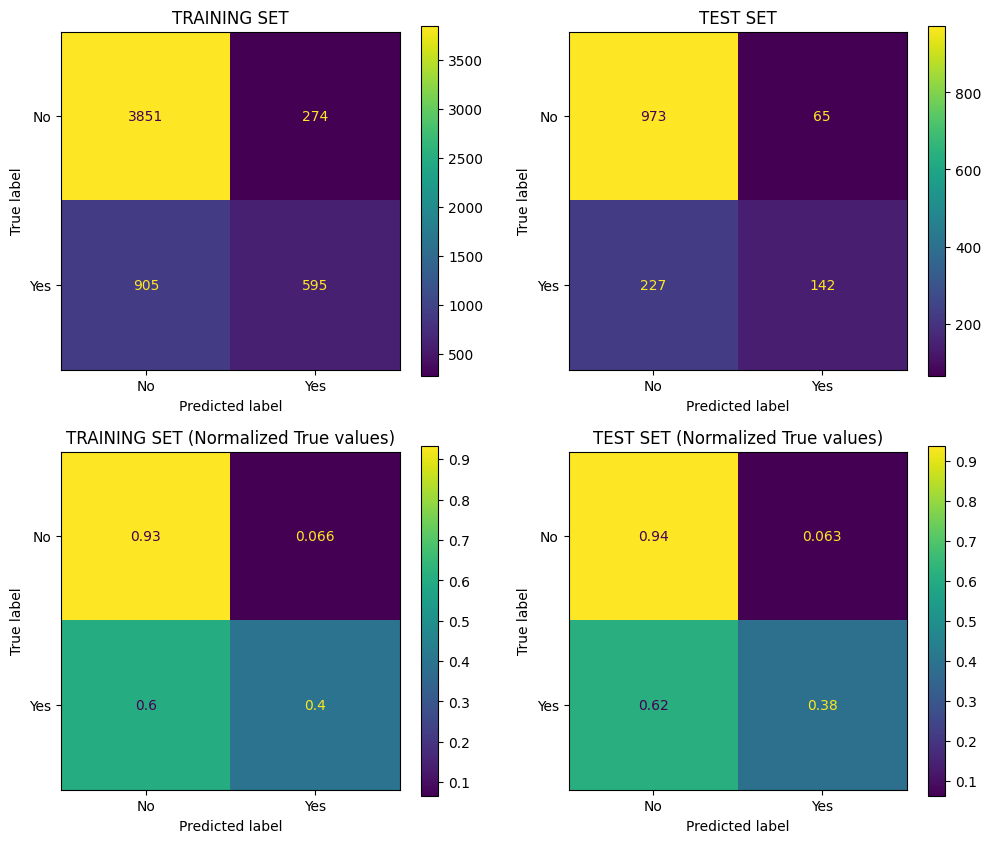

In [44]:
# accuracy and confusion matrix (TR and TS)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy in Training with max_depth=%d is %f'%(max_depth, metrics.accuracy_score(y_train,y_train_pred)))
print('Accuracy in Test set with max_depth=%d is %f'%(max_depth, metrics.accuracy_score(y_test,y_test_pred)))

fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')


ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

## Linear discriminant analysis

In [45]:
# split training and test
percentage_test_data = 0.2

df_train, df_test = train_test_split(df,
                                     test_size = percentage_test_data,  # percentage of test data
                                     random_state = 0) # seed for replication

In [46]:
# set candidate input variables (predictors)

predictors = ['tenure','MonthlyCharges']
X_train = df_train[predictors]
y_train = df_train['Churn']
X_test = df_test[predictors]
y_test = df_test['Churn']

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
df_feature_names = list(X_train.columns)
df_target_names = [str(s) for s in y_train.unique()]
X_train.head()

,tenure,MonthlyCharges
2964,24.0,58.35
5113,71.0,113.65
5363,70.0,25.35
5074,49.0,19.45
156,22.0,84.15


In [47]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

lda = lda.fit(X_train, y_train)
y_test_pred = lda.predict(X_test)
y_train_pred = lda.predict(X_train)

In [48]:
# define specific functions for plotting da

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

def plot_data(clf, X, y, y_pred):
    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        clf.means_[0][0],
        clf.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        clf.means_[1][0],
        clf.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    # covariances
    if np.size(clf.covariance_) == 4: #LDA
        plot_ellipse(plt.gca(), clf.means_[0], clf.covariance_, "red")
        plot_ellipse(plt.gca(), clf.means_[1], clf.covariance_, "blue")

    else:  #QDA (diff convariance matrix)
        plot_ellipse(plt.gca(), clf.means_[0], clf.covariance_[0], "red")
        plot_ellipse(plt.gca(), clf.means_[1], clf.covariance_[1], "blue")


<ipython-input-48-78cb0bedc70c>:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap(cmap=cmap)


LDA means:
 [[37.6729697  61.15722424]
 [17.77066667 74.34823333]]
LDA covariance:
 [[524.99394586 232.13046005]
 [232.13046005 868.29080667]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
<ipython-input-48-78cb0bedc70c>:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


Text(0, 0.5, 'Monthly charges ($)')

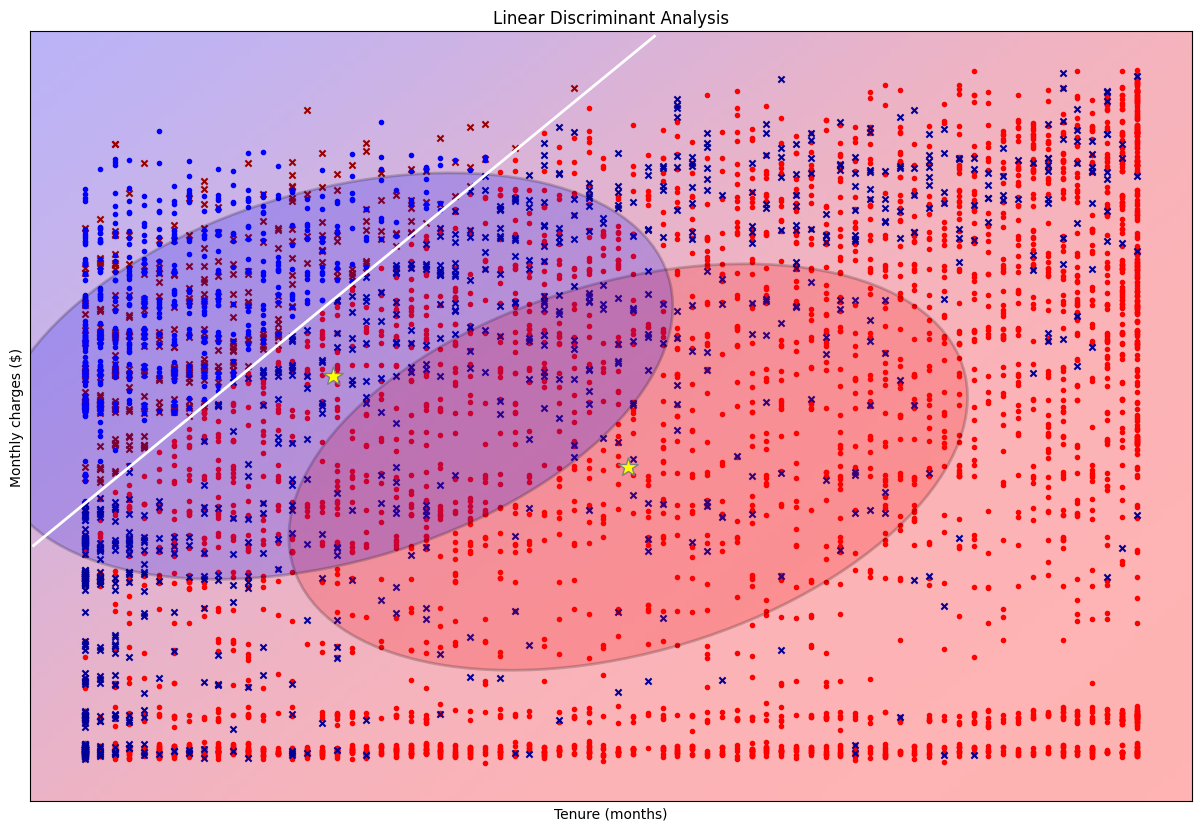

In [49]:
# LDA fitted parameters

print('LDA means:\n', lda.means_)
print('LDA covariance:\n', lda.covariance_)

plt.figure(figsize=(15, 10), facecolor="white")
plot_data(lda, X_train.to_numpy(),
               np.array([int(x) for x in (y_train=='Yes').tolist()]),
               np.array([int(x) for x in (y_train_pred=='Yes').tolist()]))
plt.title("Linear Discriminant Analysis")
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly charges ($)')

Accuracy in Training with LDA is 0.787200
Accuracy in Test set with LDA is 0.779673


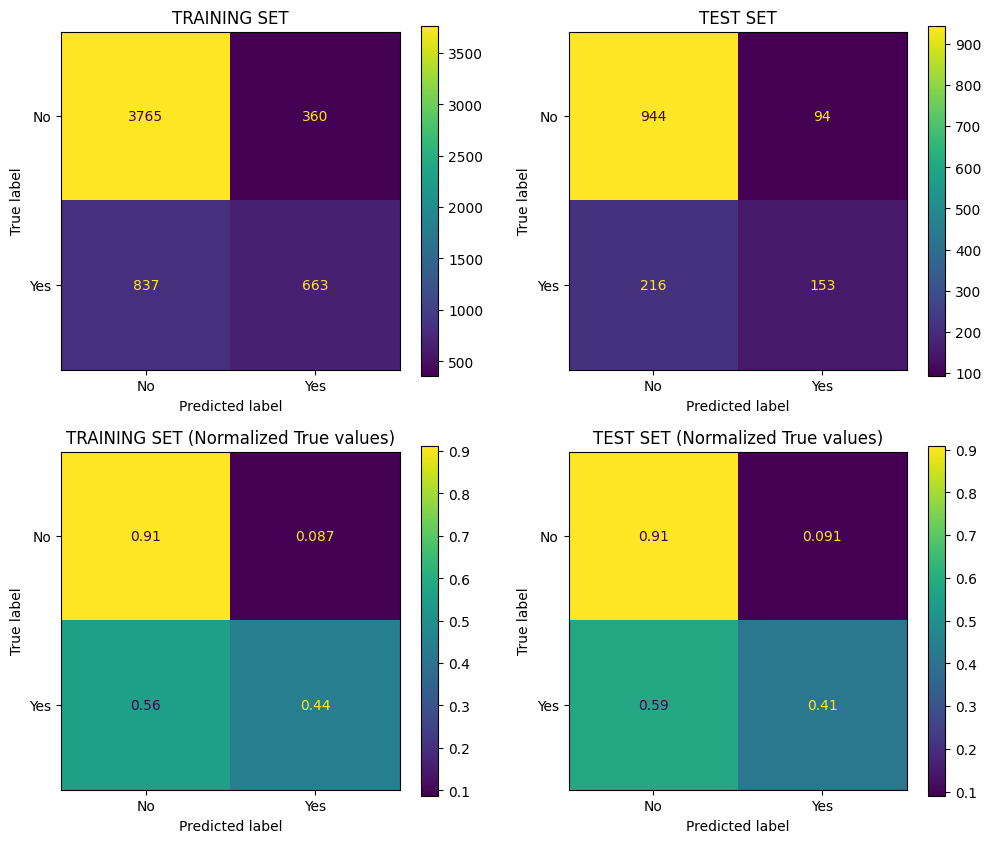

In [50]:
# accuracy and confusion matrix (TR and TS)

print('Accuracy in Training with %s is %f'%('LDA', metrics.accuracy_score(y_train,y_train_pred)))
print('Accuracy in Test set with %s is %f'%('LDA', metrics.accuracy_score(y_test,y_test_pred)))

fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(lda, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, ax = ax)
plt.title ('TEST SET')


ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(lda, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

## Quadratic Discriminant Analysis

In [51]:
# split training and test
percentage_test_data = 0.2

df_train, df_test = train_test_split(df,
                                     test_size = percentage_test_data,  # percentage of test data
                                     random_state = 0) # seed for replication

In [52]:
# set candidate input variables (predictors)

predictors = ['tenure', 'MonthlyCharges']
X_train = df_train[predictors]
y_train = df_train['Churn']
X_test = df_test[predictors]
y_test = df_test['Churn']

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
df_feature_names = list(X_train.columns)
df_target_names = [str(s) for s in y_train.unique()]
X_train.head()

,tenure,MonthlyCharges
2964,24.0,58.35
5113,71.0,113.65
5363,70.0,25.35
5074,49.0,19.45
156,22.0,84.15


In [53]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda = qda.fit(X_train, y_train)
y_test_pred = qda.predict(X_test)
y_train_pred = qda.predict(X_train)

QDA means:
 [[37.6729697  61.15722424]
 [17.77066667 74.34823333]]
QDA covariances:
 [array([[579.93303495, 247.27018562],
       [247.27018562, 964.68739445]]), array([[374.5477714 , 190.78825368],
       [190.78825368, 604.24614598]])]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
<ipython-input-48-78cb0bedc70c>:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


Text(0, 0.5, 'Monthly charges ($)')

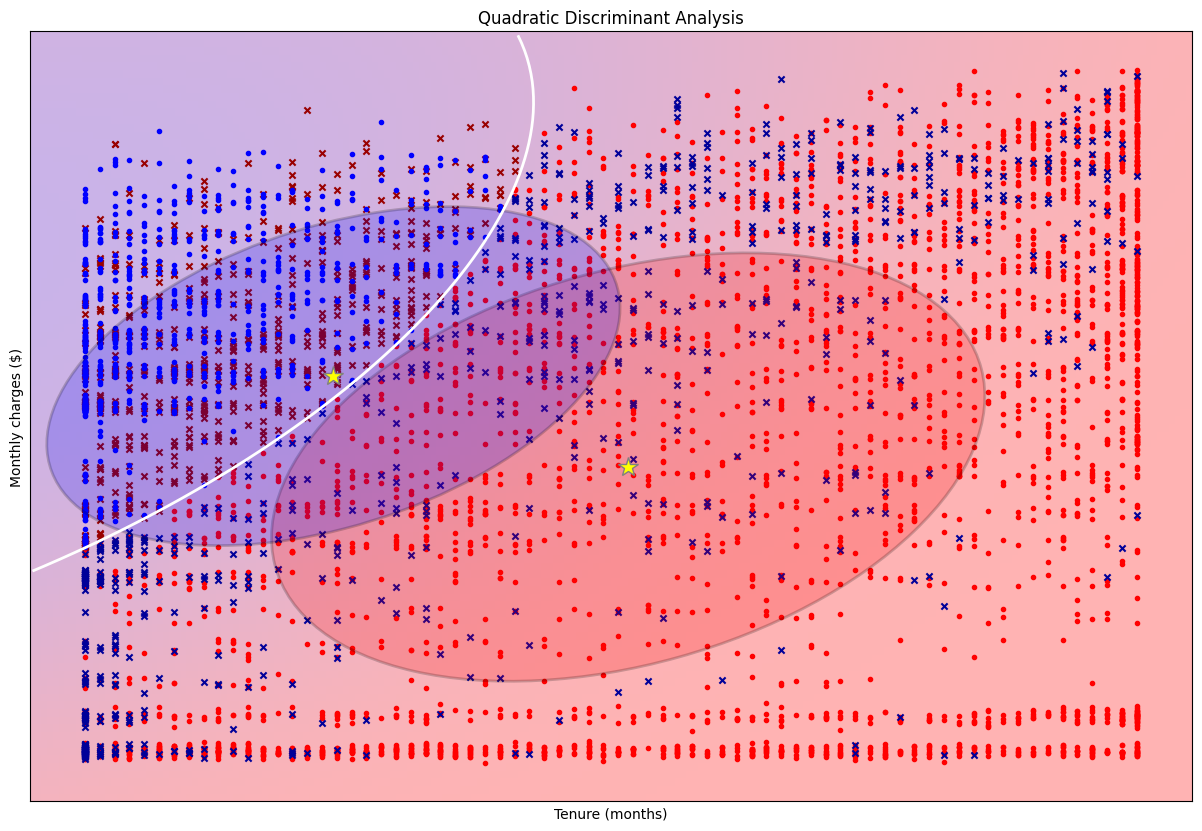

In [54]:
# QDA fitted parameters

print('QDA means:\n', qda.means_)
print('QDA covariances:\n', qda.covariance_)

plt.figure(figsize=(15, 10), facecolor="white")
plot_data(qda, X_train.to_numpy(),
               np.array([int(x) for x in (y_train=='Yes').tolist()]),
               np.array([int(x) for x in (y_train_pred=='Yes').tolist()]))
plt.title("Quadratic Discriminant Analysis")
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly charges ($)')

Accuracy in Training with QDA is 0.769422
Accuracy in Test set with QDA is 0.771855


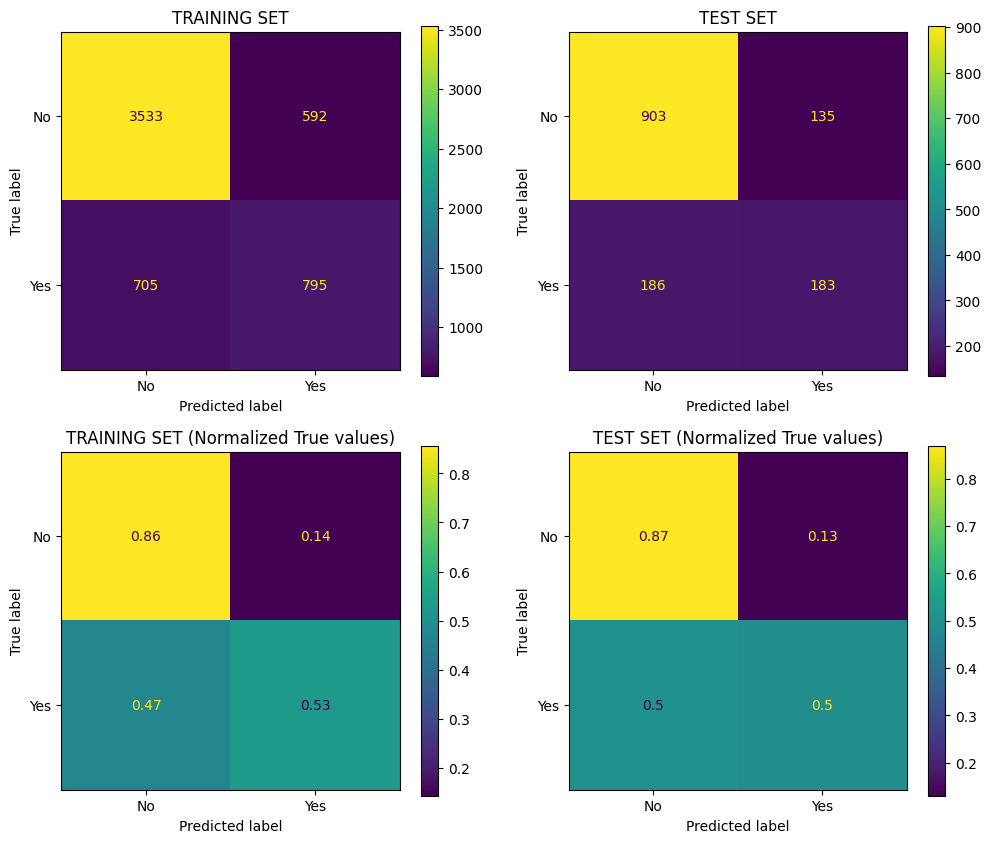

In [55]:
# accuracy and confusion matrix (TR and TS)

print('Accuracy in Training with %s is %f'%('QDA', metrics.accuracy_score(y_train,y_train_pred)))
print('Accuracy in Test set with %s is %f'%('QDA', metrics.accuracy_score(y_test,y_test_pred)))

fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(qda, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(qda, X_test, y_test, ax = ax)
plt.title ('TEST SET')


ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(qda, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(qda, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()